# Categorizing News Headlines using CNN

# Table of Contents

* Introduction
* Obtain & Scrub
* Explore
* Model
    * Word Embeddings
    * Architecture
    * Grid Search
* Evaluate
* Conclusion

# Introduction

The low barrier to entry in online publishing means that consumers of news are bombarded with news from many sources and wildly different levels of quality and accuracy. Even the savviest media consumers will find themselves fooled sometimes by convincing but distorted content.

In this project, I will attempt to tackle this problem using a Convolutional Neural Network. While more commonly applied to image classification, CNNs have been displaying promising results in text classification when applied over word embedding spaces, and I'm eager to give it a try.

I will attempt to sort news headlines accurately into three categories:
 1. Real News: Here defined as reputable news sources like the New York Times and The Guardian.
 2. Parody News: Intentially humorous works that mimic the style of real news.
 3. Clickbait: Articles with titles that are meant to draw attention, regardless of quality or accuracy.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPool1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy
from keras import initializers, regularizers, constraints, optimizers, layers

import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

# Obtain

The data will come from two sources:

1. The News Headline Dataset for Sarcasm Detection, obtainable here: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection
2. The Clickbait and Non-Clickbait datasets found here: https://github.com/bhargaviparanjape/clickbait/tree/master/dataset. This is the source data for "Stop Clickbait: Detecting and preventing clickbaits in online news media", authored by Chakraborty, Abhijnan and Paranjape, Bhargavi and Kakarla, Sourya and Ganguly, Niloy, published in *Advances in Social Networks Analysis and Mining (ASONAM).*

The following function loads the data, strips punctuation, equalizes the lengths, one-hot encodes the sources, and then combines everything into a single dataset.

In [6]:
def load_data():

    seed = 7

    parody = pd.read_csv('../data/processed/parody.csv')
    parody.drop(['Unnamed: 0', 'article_link', 'is_parody'], axis=1, inplace=True)

    clickbait = open('../data/raw/clickbait_data', mode='r')
    clickbait = [line for line in clickbait]
    clickbait = pd.DataFrame({"headline": clickbait})
    clickbait = clickbait[clickbait['headline'] != '\n']
    clickbait = clickbait['headline'].str.replace('\n', '')
    clickbait = pd.DataFrame(clickbait)
    clickbait.dropna(inplace=True)
    clickbait.headline = clickbait.headline.str.lower()

    real = open('../data/raw/non_clickbait_data', mode='r')
    real = [line for line in real]
    real = pd.DataFrame({"headline": real})
    real = real[real['headline'] != '\n']
    real = real['headline'].str.replace('\n', '')
    real = pd.DataFrame(real)
    real.dropna(inplace=True)
    real.headline = real.headline.str.lower()

    table = str.maketrans('', '', string.punctuation)

    real.headline = real.headline.str.translate(table)
    parody.headline = parody.headline.str.translate(table)
    clickbait.headline = clickbait.headline.str.translate(table)

    real['real'] = 1
    real['parody'] = 0
    real['clickbait'] = 0

    parody['real'] = 0
    parody['parody'] = 1
    parody['clickbait'] = 0

    clickbait['real'] = 0
    clickbait['parody'] = 0
    clickbait['clickbait'] = 1
    
    real = real.sample(n=11725, random_state=seed)
    clickbait = clickbait.sample(n=11725, random_state=seed)

    df = pd.concat([real, parody, clickbait])
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [7]:
df = load_data()

In [8]:
df.head()

,headline,real,parody,clickbait
0,dominos introduces thanksgiving feast pizza,0,1,0
1,25 ridiculously romantic moments that made us ...,0,0,1
2,apple inc doubled its profits,1,0,0
3,myanmar dissident suu kyi to run for parliamen...,1,0,0
4,worlds fattest town makes consumes worlds larg...,0,1,0


# Explore

To do: Word clouds, most unique words, word embedding charts.

# Model

From here, we'll need to 

In [9]:
def splitter(df, train_percent):

    train_size = int(df.shape[0] * train_percent)

    X_train = df.iloc[:train_size, 0]
    X_test = df.iloc[train_size:, 0]
    y_train = df.iloc[:train_size, 1:]
    y_test = df.iloc[train_size:, 1:]

    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = splitter(df, .90)

In [20]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))

In [21]:
def token_lists(X_train, X_test, tokenizer):
    
    list_tokenized_train = tokenizer.texts_to_sequences(X_train)
    list_tokenized_test = tokenizer.texts_to_sequences(X_test)

    return list_tokenized_train, list_tokenized_test

In [22]:
list_tokenized_train, list_tokenized_test = token_lists(X_train, X_test, tokenizer)

In [23]:
maxlen = 18
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_t = np.array(y_train)
y_te = np.array(y_test)

In [24]:
def get_embedding(list_tokenized_train, list_tokenized_test, tokenizer):

    tokens = tokenizer.sequences_to_texts(list_tokenized_train) + tokenizer.sequences_to_texts(list_tokenized_test)
    tokens = [t.split(' ') for t in tokens]
    model = Word2Vec(tokens, size=100, window=5, min_count=1, workers=4)
    model.train(tokens, total_examples=model.corpus_count, epochs=10)
    embeddings = model.wv
    keras_embedding = embeddings.get_keras_embedding()

    return keras_embedding

# Architecture

In [79]:
def news_conv_model(x_train, y_train, x_val, y_val, params):
    
    keras_embedding = get_embedding(list_tokenized_train, list_tokenized_test, tokenizer)
    
    # define base model
    model = Sequential()
    model.add(keras_embedding)
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=params['lr']),
        metrics=['accuracy'])

    # fit model
    hist = model.fit(X_t, y_t, 
                     validation_data=[x_val, y_val], 
                     batch_size=params['batch_size'], 
                     epochs=params['epochs'], 
                     verbose=0)

    return hist, model

# Grid Search

There are a ton of hyperparameters to tune, and this is a cutting-edge area, so there are no hard and fast rules as of yet. In order to sift through the possibilities, we'll use a grid search library for Keras called Talos.

Because training takes such a long time, we'll focus in on the most important parameters specified in this tuning write-up: https://towardsdatascience.com/a-walkthrough-of-convolutional-neural-network-7f474f91d7bd

In [86]:
p = {
    'lr': [.01, .001, .0001],
    'batch_size': [16, 64, 128],
    'epochs': [15, 50]
}

In [85]:
t = ta.Scan(x=X_t,
            y=y_t,
            x_val=X_te,
            y_val=y_te,
            model=news_conv_model,
            params=p,
            val_split=.1,
            dataset_name='news_nlp',
            experiment_no='2')







  0%|          | 0/18 [00:00<?, ?it/s]





  6%|▌         | 1/18 [01:14<21:09, 74.70s/it]





 11%|█         | 2/18 [03:38<25:26, 95.40s/it]





 17%|█▋        | 3/18 [08:18<37:42, 150.84s/it]





 22%|██▏       | 4/18 [09:44<30:39, 131.42s/it]





 28%|██▊       | 5/18 [17:47<51:17, 236.72s/it]





 33%|███▎      | 6/18 [19:23<38:56, 194.67s/it]





 39%|███▉      | 7/18 [21:54<33:17, 181.55s/it]





 44%|████▍     | 8/18 [23:23<25:37, 153.80s/it]





 50%|█████     | 9/18 [28:09<28:59, 193.33s/it]





 56%|█████▌    | 10/18 [29:27<21:11, 158.92s/it]





 61%|██████    | 11/18 [34:23<23:19, 199.88s/it]





 67%|██████▋   | 12/18 [38:24<21:13, 212.32s/it]





 72%|███████▏  | 13/18 [42:27<18:27, 221.55s/it]





 78%|███████▊  | 14/18 [50:56<20:30, 307.63s/it]





 83%|████████▎ | 15/18 [59:48<18:44, 374.92s/it]





 89%|████████▉ | 16/18 [1:04:03<11:18, 339.13s/it]





 94%|█████████▍| 17/18 [1:06:52<04:48, 288.14s/it]





100%|██████████| 18/18 [1:08:10<00:00, 

Scan Finished!


# Evaluate

That took forever! Let's see what the best combination of hyperparameters was.

In [87]:
r = ta.Reporting("news_nlp_2.csv")

In [96]:
r.data.sort_values('val_acc', ascending=False)

,round_epochs,val_loss,val_acc,loss,acc,lr,batch_size,epochs
7,15,0.498237,0.795907,0.313061,0.869381,0.0010,64,15
15,50,0.489061,0.795623,0.148945,0.938339,0.0010,128,50
16,15,0.489057,0.792780,0.317923,0.866601,0.0010,16,15
4,50,0.507717,0.792780,0.241219,0.900749,0.0001,16,50
11,50,0.501958,0.791927,0.380615,0.839404,0.0001,128,50
13,50,0.491914,0.790222,0.155028,0.936728,0.0010,16,50
0,15,0.500350,0.788800,0.327321,0.861073,0.0010,128,15
10,50,0.516418,0.787379,0.317263,0.867897,0.0001,64,50
8,50,0.493342,0.783968,0.144611,0.941150,0.0010,64,50
6,15,0.500750,0.780841,0.425382,0.817639,0.0001,16,15


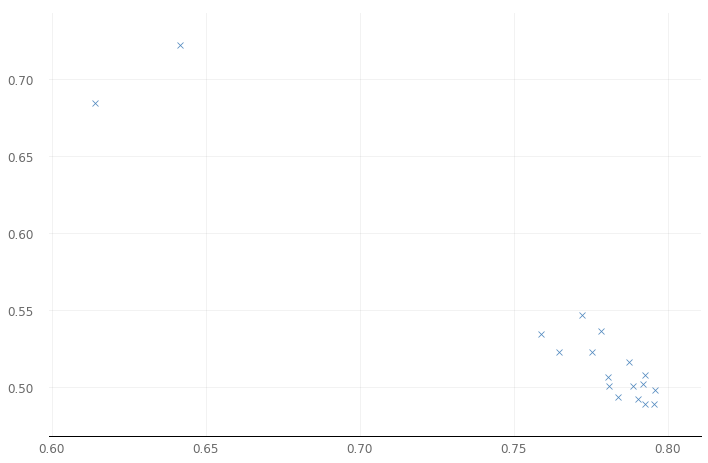

In [97]:
r.plot_regs()

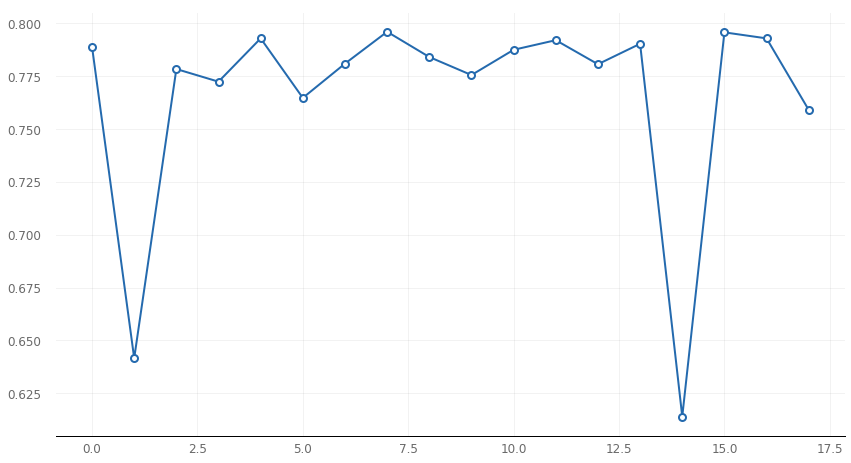

In [98]:
r.plot_line()

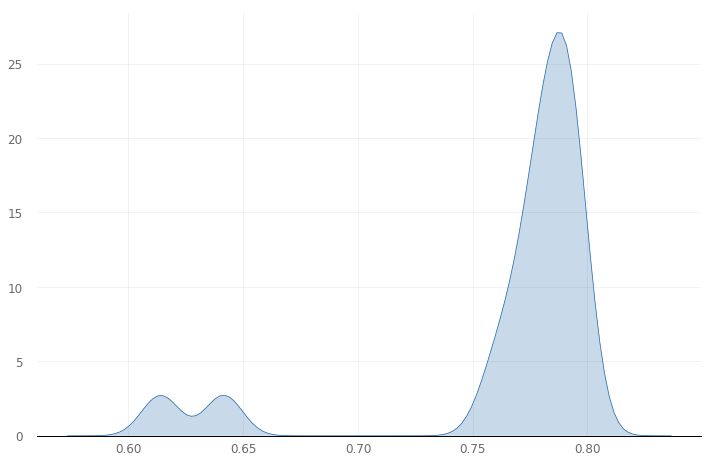

In [99]:
r.plot_kde('val_acc')

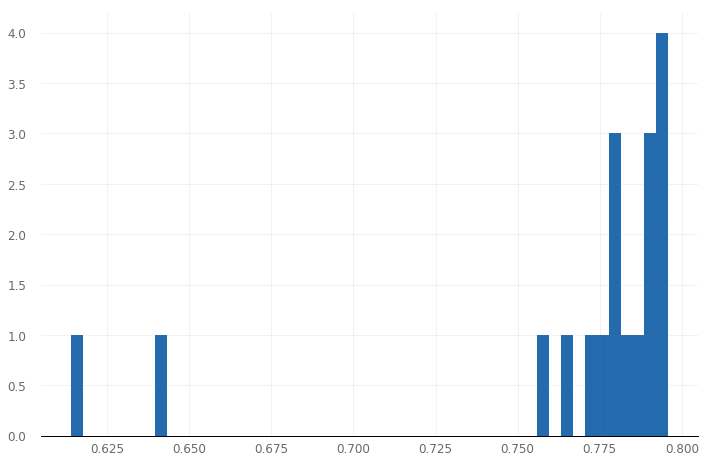

In [100]:
r.plot_hist(bins=50)

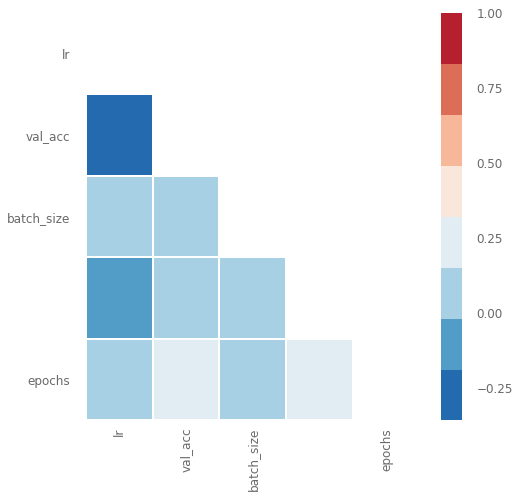

In [101]:
r.plot_corr()

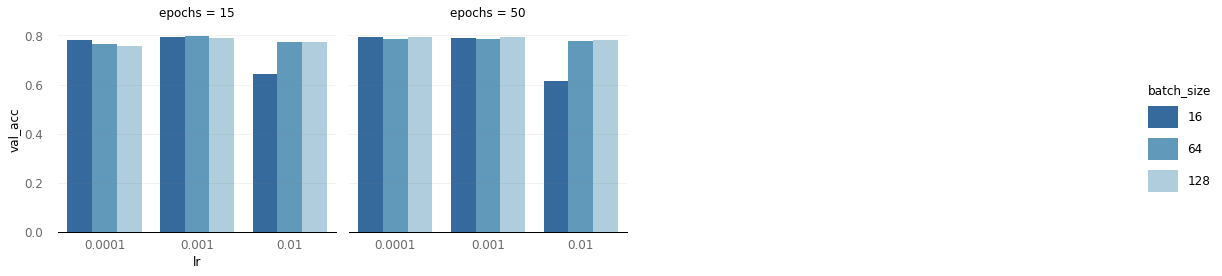

In [103]:
r.plot_bars('lr', 'val_acc', 'batch_size', 'epochs')

# Conclusion

